In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import quandl

import matplotlib
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

from pylab import rcParams # This will define a fixed size for all special charts.
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf


warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 

#quandl.ApiConfig.api_key = 'yourAPIkey'
quandl.ApiConfig.api_key = 'rnAqnpuiPHwmoLztmbXi'

In [3]:
# This command propts matplotlib visuals to appear in the notebook 

%matplotlib inline

In [4]:
data_files_paths = '../02 Data/Original Data/Airbnb Amsterdam/'

In [5]:
# Import files into pandas DataFrames
calendar = pd.read_csv(data_files_paths + 'calendar.csv', parse_dates=['date'], index_col=['listing_id'])
listings = pd.read_csv(data_files_paths + 'listings.csv', index_col= "id")
reviews_details = pd.read_csv(data_files_paths + 'reviews_details.csv', parse_dates=['date'], index_col=['id'])
reviews = pd.read_csv(data_files_paths + 'reviews.csv', parse_dates=['date'], index_col=['listing_id'])
listings_details = pd.read_csv(data_files_paths + 'listings_details.csv', index_col= "id", low_memory=False)
neighbourhoods = pd.read_csv(data_files_paths + 'neighbourhoods.csv')

## Q3  Data standardizing

### Added new hypothesis,  To perform time series analiysis, 

#### e. Seasonal and temporal factors influence listing prices and demand.

Do prices fluctuate depending on the time of the year (e.g., peak seasons, holidays)?

Are there specific months or days of the week when the demand for listings is higher based on the number of bookings or availability?

Is there a relationship between the time of the year and the number of reviews a listing receives?

In [6]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7310950 entries, 2818 to 29979667
Data columns (total 3 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date       datetime64[ns]
 1   available  object        
 2   price      object        
dtypes: datetime64[ns](1), object(2)
memory usage: 223.1+ MB


In [7]:
calendar.describe()

,date,available,price
count,7310950,7310950,1200071
unique,366,2,1036
top,2019-12-05 00:00:00,f,$150.00
freq,20030,6110879,51829
first,2018-12-06 00:00:00,NaN,NaN
last,2019-12-06 00:00:00,NaN,NaN


In [8]:
# Checking for nulls
calendar.isnull().sum()

date               0
available          0
price        6110879
dtype: int64

In [13]:
# Convert the 'price' column to a numerical format
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)

# Convert the 'available' column to a numerical format (1 for True, 0 for False)
calendar['available'] = calendar['available'].map({'t': 1, 'f': 0})

# Set the 'date' column as the index of the DataFrame
calendar_reset_index = calendar.reset_index()

calendar_reset_index.shape

(7310950, 4)

In [15]:
calendar_reset_index.head()

,listing_id,date,available,price
0,2818,2019-12-05,NaN,NaN
1,73208,2019-08-30,NaN,NaN
2,73208,2019-08-29,NaN,NaN
3,73208,2019-08-28,NaN,NaN
4,73208,2019-08-27,NaN,NaN


In [16]:
# Calculate the daily average price, availability, and count of reviews
daily_aggregates = calendar_reset_index.groupby('date').agg({
    'price': 'mean',
    'available': 'mean',
    'listing_id': 'count'  # Assuming that each row represents a unique review
})

# Rename the 'listing_id' column to 'reviews_count'
daily_aggregates.rename(columns={'listing_id': 'reviews_count'}, inplace=True)


daily_aggregates.shape

(366, 3)

In [17]:
# Set the 'date' column as the index of the DataFrame
calendar_date_index = daily_aggregates.reset_index().set_index('date')

# Display the first few rows of the new DataFrame
calendar_date_index.head()

,price,available,reviews_count
date,,,
2018-12-06,180.292929,NaN,19183
2018-12-07,224.468399,NaN,20030
2018-12-08,227.502031,NaN,20030
2018-12-09,184.010435,NaN,20030
2018-12-10,172.021444,NaN,20030


In [ ]:
# Select relevant columns from listings and listings_details
listings_columns = ['neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'number_of_reviews', 'availability_365']
listings_details_columns = ['host_response_time', 'host_is_superhost', 'property_type', 'accommodates', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

# Extract the relevant columns
listings_filtered = listings[listings_columns]
listings_details_filtered = listings_details[listings_details_columns]

# Merge the DataFrames
merged_listings = pd.merge(listings_filtered, listings_details_filtered, on='id')

## Q4 Create a line chart of your data.

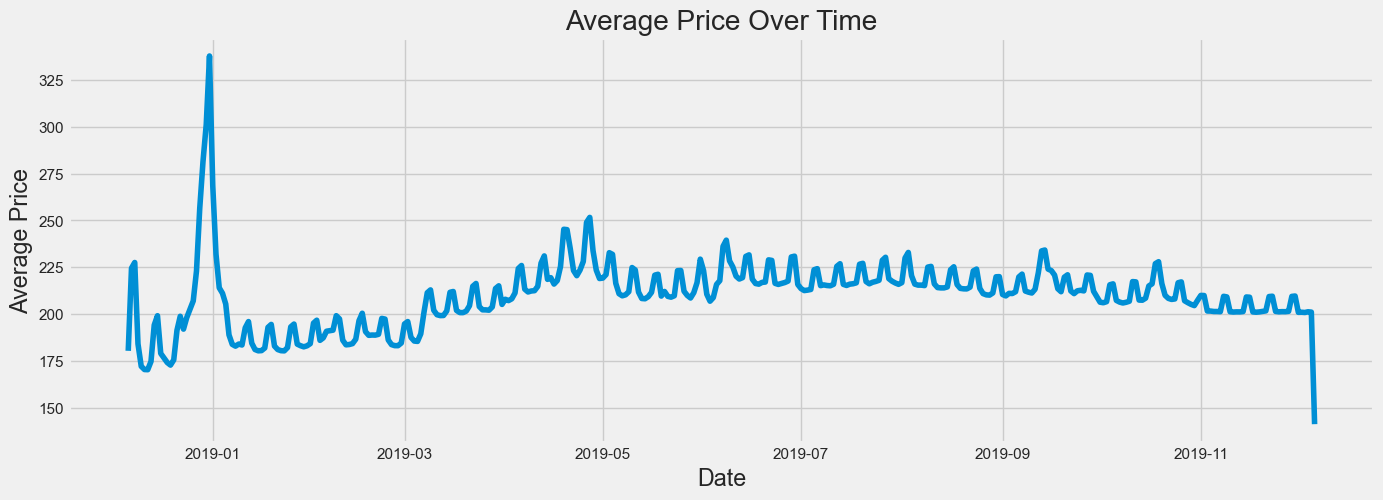

In [18]:
# Plot the data using matplotlib.
plt.figure(figsize=(15, 5), dpi=100)
plt.plot(calendar_date_index['price'])
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price Over Time')
plt.show()

## Q5 Decompose the data’s components

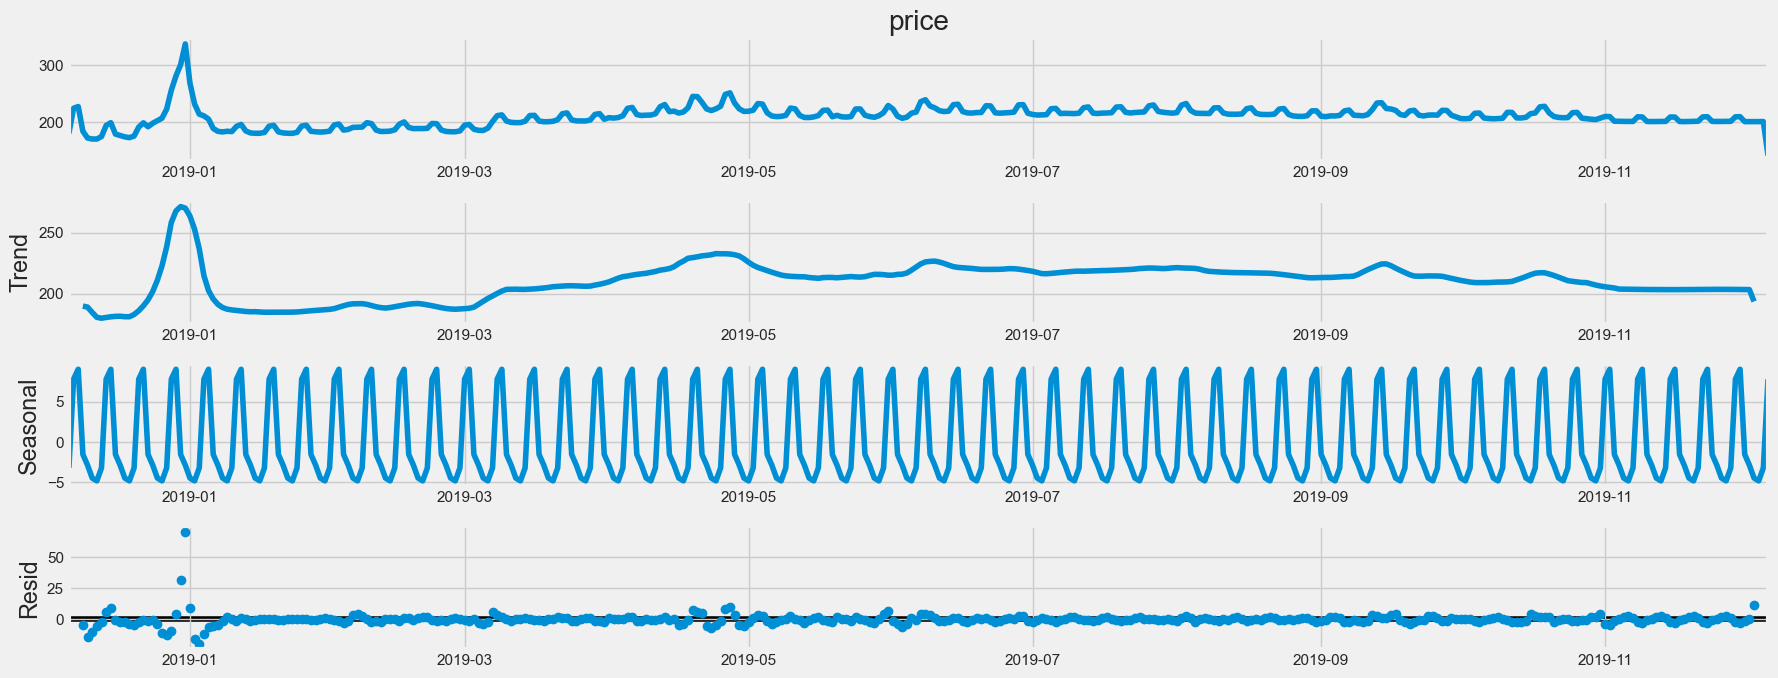

In [21]:
# Resample the DataFrame to fill missing dates and interpolate missing values
calendar_date_index_resampled = calendar_date_index.resample('D').mean()
calendar_date_index_resampled.interpolate(method='linear', inplace=True)

# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(calendar_date_index_resampled['price'], model='additive')

# Plot the separate components
rcParams['figure.figsize'] = 18, 7
decomposition.plot()
plt.show()

## Q6 Conduct a Dickey-Fuller test to check for stationarity.

In [22]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries):
    print('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key, value in test[4].items():
        result['Critical Value (%s)' % key] = value
    print(result)

# Apply the test using the function on the time series
dickey_fuller(calendar_date_index_resampled['price'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.835196
p-value                          0.053419
Number of Lags Used             15.000000
Number of Observations Used    350.000000
Critical Value (1%)             -3.449173
Critical Value (5%)             -2.869833
Critical Value (10%)            -2.571188
dtype: float64


The test statistic (-2.835196) is greater than all the critical values, which means we fail to reject the null hypothesis at all significance levels (1%, 5%, and 10%). The null hypothesis of the Dickey-Fuller test is that the time series is non-stationary. As we fail to reject the null hypothesis, it suggests that the time series is non-stationary.

The p-value (0.053419) is greater than the commonly used significance levels (e.g., 0.01, 0.05, or 0.10). A high p-value also indicates that we fail to reject the null hypothesis, and the time series is likely non-stationary.

In conclusion, the Dickey-Fuller test results suggest that the time series is non-stationary. To use time series models that assume stationarity, we might need to apply techniques such as differencing or transformation to make the series stationary before proceeding with the analysis.

## Q7 Conducting rounds of differencing on dataframe.

### Automatic stationarizetion
This code contains the Dickey-Fuller test function, the stationarize function, and the iterative process to perform differencing and test for stationarity until the null hypothesis can be rejected at all significance levels (1%, 5%, and 10%). The output shows the number of attempts required for each level, a plot of the time series after the final round of differencing, and the Dickey-Fuller test results after the last round of differencing.
This code now checks both the Dickey-Fuller test results and the maximum absolute autocorrelation before updating the number of attempts required to reject the null hypothesis. It also plots the autocorrelation of the final differenced data at the end.

In [30]:
# Define the function for the Dickey-Fuller test
def dickey_fuller(timeseries):
    # Perform the Dickey-Fuller test and store the results in a pandas Series
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    # Add the critical values for different significance levels to the results
    for key, value in test[4].items():
        result['Critical Value (%s)' % key] = value
    return result

# Define the function for differencing and stationarity analysis
def stationarize(data, rounds=1):
    # Create a copy of the input data and perform differencing for the specified number of rounds
    data_diff = data.copy()
    for _ in range(rounds):
        data_diff = data_diff - data_diff.shift(1)
    # Remove missing values resulting from differencing
    return data_diff.dropna()

Attempts to reject the null hypothesis:
1%: 1 attempts
5%: 1 attempts
10%: 1 attempts


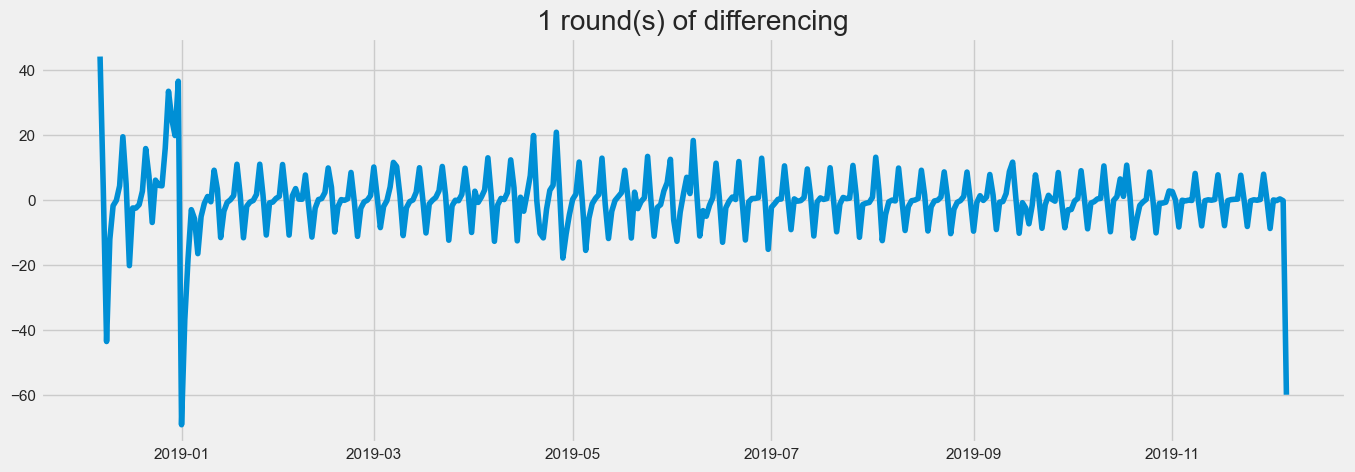


Dickey-Fuller Stationarity test results after the final round of differencing:
Test Statistic                  -5.637413
p-value                          0.000001
Number of Lags Used             14.000000
Number of Observations Used    350.000000
Critical Value (1%)             -3.449173
Critical Value (5%)             -2.869833
Critical Value (10%)            -2.571188
dtype: float64


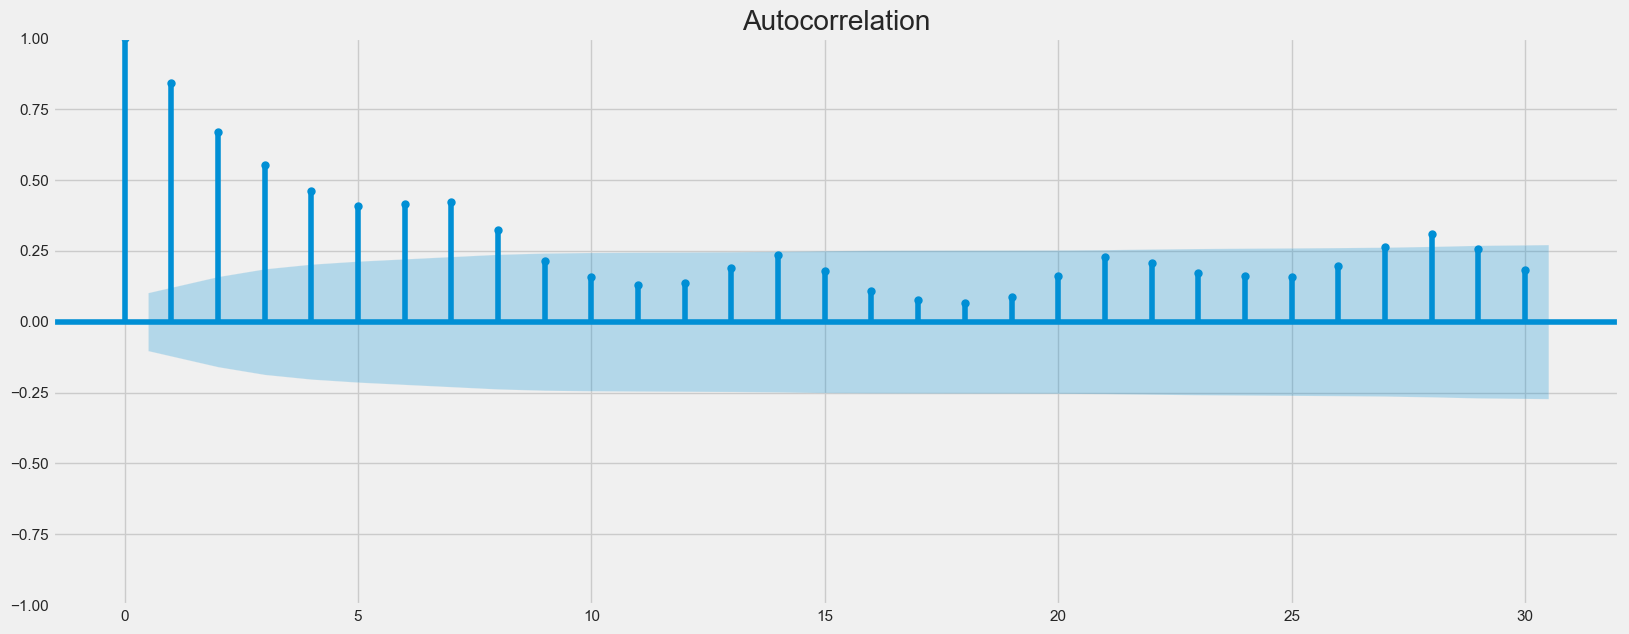


Autocorrelation levels:
    Lag  Autocorrelation
0     0         1.000000
1     1         0.210895
2     2        -0.195750
3     3        -0.127891
4     4        -0.162563
5     5        -0.224342
6     6         0.029481
7     7         0.393236
8     8         0.034071
9     9        -0.194402
10   10        -0.115683
11   11        -0.131829
12   12        -0.178417
13   13         0.046374
14   14         0.381495
15   15         0.048847
16   16        -0.139804
17   17        -0.079347
18   18        -0.118003
19   19        -0.180867
20   20         0.032895
21   21         0.352515
22   22         0.055461
23   23        -0.055785
24   24        -0.012929
25   25        -0.131883


In [35]:
# Load the data and initialize the counter for attempts to reject the null hypothesis
data = calendar_date_index_resampled['price']
rounds = 1
attempts = {'1%': 0, '5%': 0, '10%': 0}
max_rounds = 20  # Set a maximum number of rounds to avoid infinite loops

# Continue differencing and testing for stationarity until the null hypothesis can be rejected at all significance levels or maximum rounds reached
while not all(attempts.values()) and rounds <= max_rounds:
    # Perform differencing for the current number of rounds
    diff_data = stationarize(data, rounds)
    # Perform the Dickey-Fuller test on the differenced data
    df_test = dickey_fuller(diff_data)

    # Update the number of attempts required to reject the null hypothesis at each significance level
    for level in attempts:
        if attempts[level] == 0 and df_test['Test Statistic'] < df_test[f'Critical Value ({level})']:
            attempts[level] = rounds

    # Increment the number of differencing rounds
    rounds += 1

# Print the number of attempts required to reject the null hypothesis at each significance level
print("Attempts to reject the null hypothesis:")
for level, attempt in attempts.items():
    print(f"{level}: {attempt} attempts")

# Plot the time series after the final round of differencing
plt.figure(figsize=(15, 5), dpi=100)
plt.plot(diff_data)
plt.title(f'{rounds - 1} round(s) of differencing')
plt.show()

# Print the Dickey-Fuller test results after the final round of differencing
print("\nDickey-Fuller Stationarity test results after the final round of differencing:")
print(df_test)

# Plot the autocorrelation
plot_acf(calendar_date_index_resampled['price'], lags=30)
plt.show()

# Compute the autocorrelation of the stationarized data
autocorrelation = acf(diff_data)

# Create a pandas DataFrame to display the autocorrelation as a table
autocorrelation_df = pd.DataFrame({'Lag': range(len(autocorrelation)), 'Autocorrelation': autocorrelation})

# Print the autocorrelation table
print("\nAutocorrelation levels:")
print(autocorrelation_df)


Dickey-Fuller Stationarity test results indicate that the data is stationary, as the test statistic is lower than the critical values at 1%, 5%, and 10% significance levels. This is suitable for time series forecasting models, as most of them require the data to be stationary.

The autocorrelation levels show the correlation between the time series and its lagged versions. Some lags have significant positive or negative autocorrelations, which can be useful when selecting the parameters for forecasting models like ARIMA or SARIMA.

In conclusion, the data is stationary and has some significant autocorrelation, making it suitable for forecasting using time series models.

## Q9 Check data’s autocorrelations.

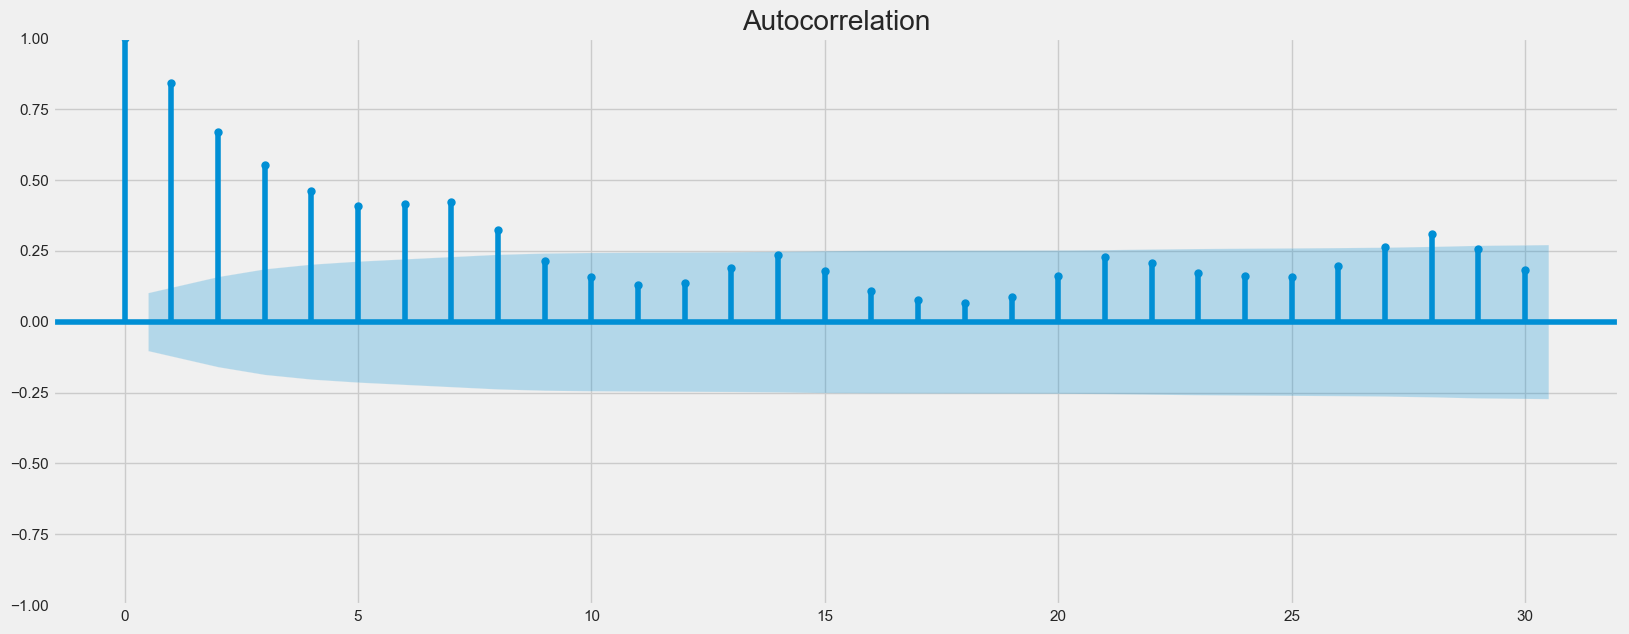

In [36]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the autocorrelation
plot_acf(calendar_date_index_resampled['price'], lags=30)
plt.show()